In [2]:
from scipy.interpolate import interp1d
import numpy as np
from numpy.polynomial.chebyshev import Chebyshev
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import haiku
import optax
from Tasmanian import TasmanianSparseGrid
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import concurrent.futures
from scipy.interpolate import RegularGridInterpolator
import time
import multiprocessing
from pathlib import Path
PATH = Path('/bbkinghome/mbarrera/git_supply/14_462/recitation_1')
plt.rcParams['figure.figsize'] = (8,6)


# Interpolation

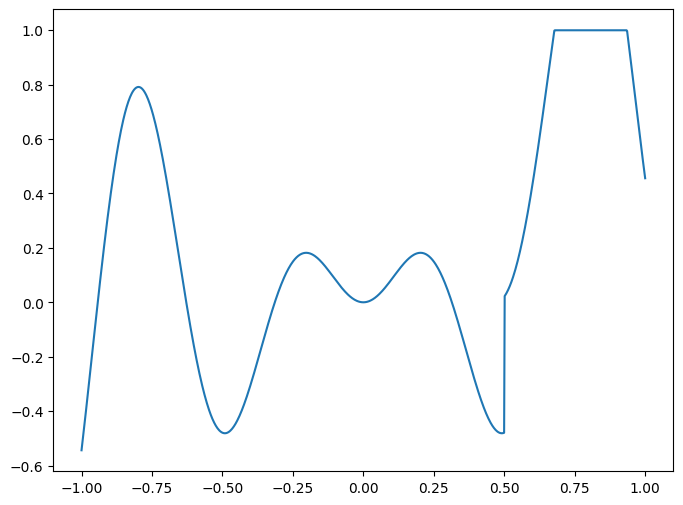

In [3]:
def function_1d(x):
    return np.minimum(x*np.sin(10*x)+np.where(x>0.5,x,0),1)

x = np.linspace(-1,1,1000)

fig,ax=plt.subplots()
ax.plot(x,function_1d(x))
fig.show()
fig.savefig(PATH / 'figures/target.pdf')

## Classical Interpolation

In [4]:
x_train =  np.linspace(-1,1,17)
y_train = function_1d(x_train)
iterpolator_linear = interp1d(x_train, y_train, fill_value='extrapolate',kind='linear')
iterpolator_quadratic = interp1d(x_train, y_train, fill_value='extrapolate',kind='quadratic')
iterpolator_cubic = interp1d(x_train, y_train, fill_value='extrapolate',kind='cubic')

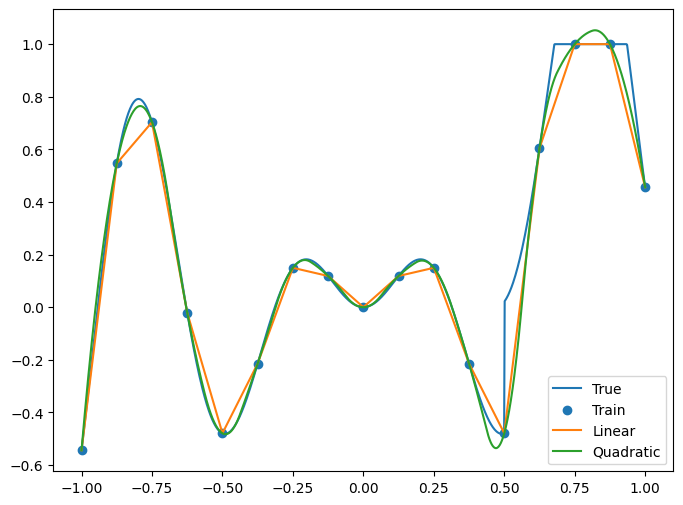

In [5]:
x_test = np.linspace(-1,1,1000)

fig,ax=plt.subplots()
ax.plot(x,function_1d(x),label='True')
ax.scatter(x_train,function_1d(x_train),label='Train')
ax.plot(x_test,iterpolator_linear(x_test),label='Linear')
ax.plot(x_test,iterpolator_quadratic(x_test),label='Quadratic')
ax.legend()
fig.show()
fig.savefig(PATH / 'figures/classic_interpolation.pdf')

## Chebyshev polynomials

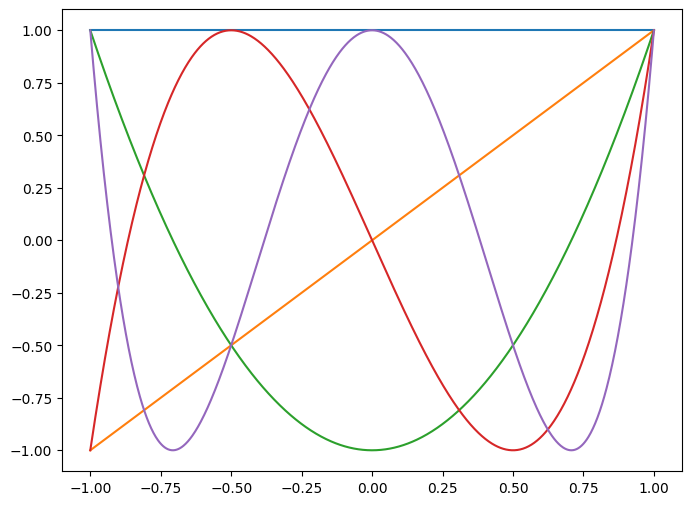

In [6]:
fig,ax=plt.subplots()
ax.plot(x,Chebyshev(coef=[1])(x))
ax.plot(x,Chebyshev(coef=[0,1])(x))
ax.plot(x,Chebyshev(coef=[0,0,1])(x))
ax.plot(x,Chebyshev(coef=[0,0,0,1])(x))
ax.plot(x,Chebyshev(coef=[0,0,0,0,1])(x))
fig.show()
fig.savefig(PATH / 'figures/chevysev_polyomials.pdf')

In [7]:
chevysev_interpolator = Chebyshev.interpolate(func=function_1d, deg=10)
chevysev_interpolator

Chebyshev([ 0.27203856,  0.38623047,  0.20827791,  0.07534901, -0.27252225,
        0.04840033, -0.36361181,  0.0586281 ,  0.03059249, -0.08590992,
        0.18544269], domain=[-1.,  1.], window=[-1,  1], symbol='x')

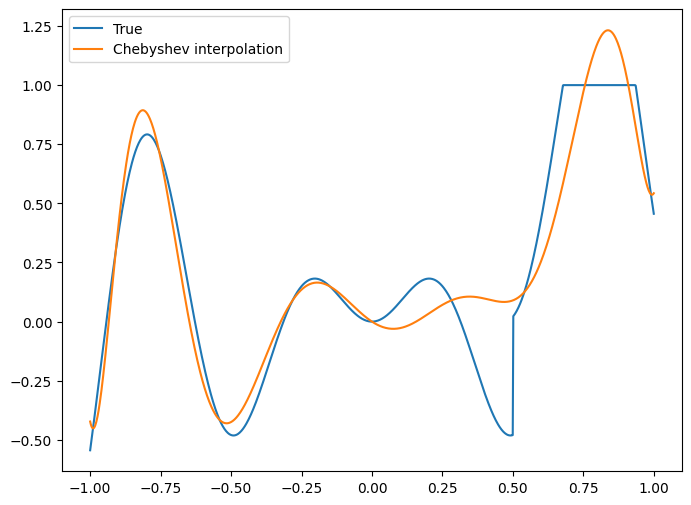

In [8]:
fig,ax=plt.subplots()
ax.plot(x,function_1d(x),label='True')
#ax.scatter(x_train,function_1d(x_train),label='Train')
ax.plot(x_test,chevysev_interpolator(x_test),label='Chebyshev interpolation')
ax.legend()
fig.show()
fig.savefig(PATH / 'figures/chevyshev_interpolation.pdf')

## Sparse Grids

Note: no much gain in using sparse grids in 1-D. The benefits of sparse grids are higher the higher the number of dimentions of the function.

In [9]:
grid  = TasmanianSparseGrid()
grid.makeLocalPolynomialGrid(iDimension=1, iOutputs=1, iDepth=4, iOrder=2)
x_train = grid.getPoints()
y_train = function_1d(x_train)
grid.loadNeededPoints(y_train)

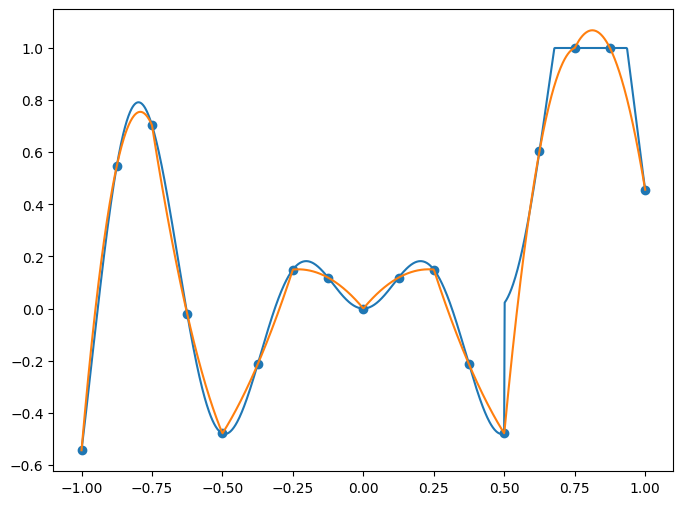

In [10]:
fig,ax=plt.subplots()
ax.plot(x,function_1d(x))
ax.scatter(x_train,function_1d(x_train))
ax.plot(x_test, grid.evaluateBatch(x_test.reshape(-1,1)))
fig.show()
fig.savefig(PATH / 'figures/sparse_grid.pdf')

## Adaptive Sparse Grid

Define the grid

In [11]:
adaptive_grid  = TasmanianSparseGrid()
adaptive_grid.makeLocalPolynomialGrid(iDimension=1, iOutputs=1, iDepth=1, iOrder=1)
x_train = adaptive_grid.getNeededPoints()
y_train=function_1d(x_train)
adaptive_grid.loadNeededPoints(y_train)

Refine

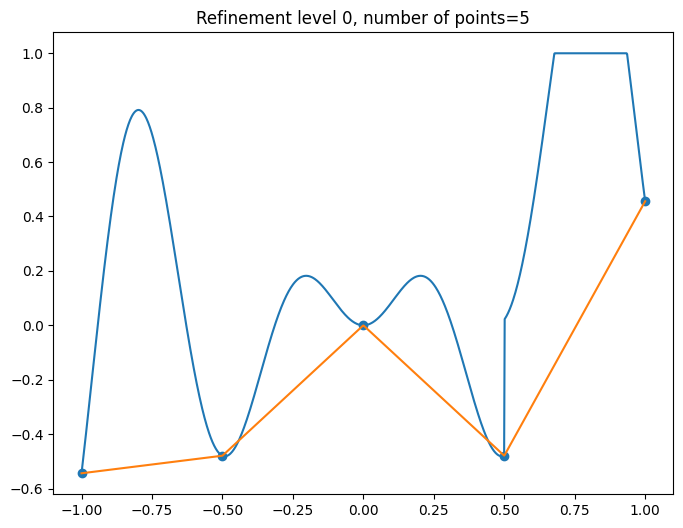

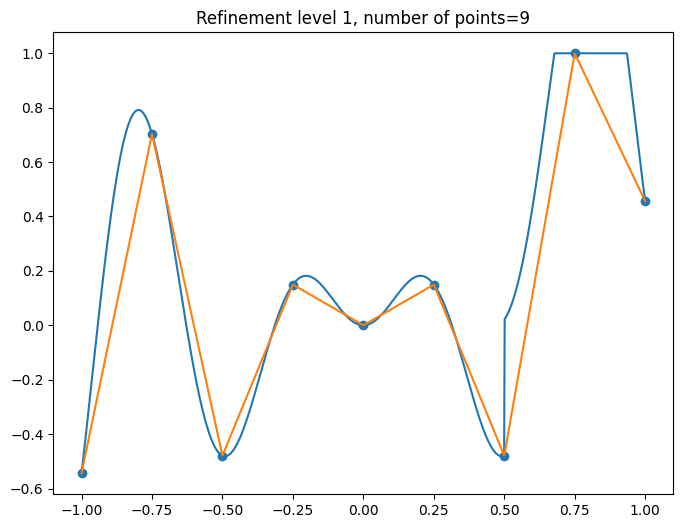

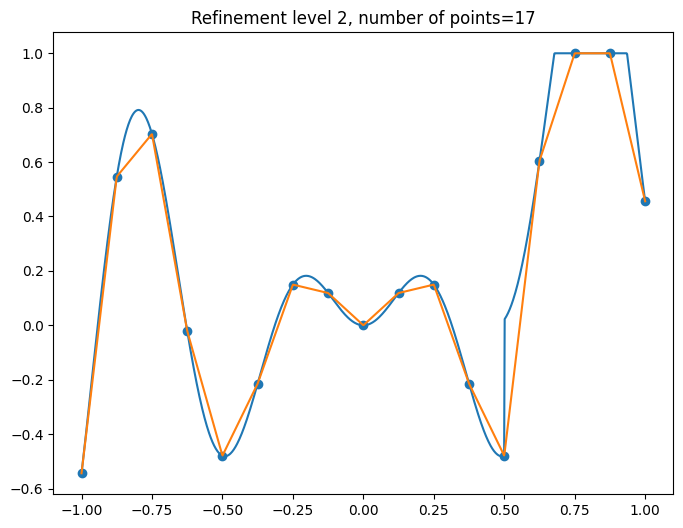

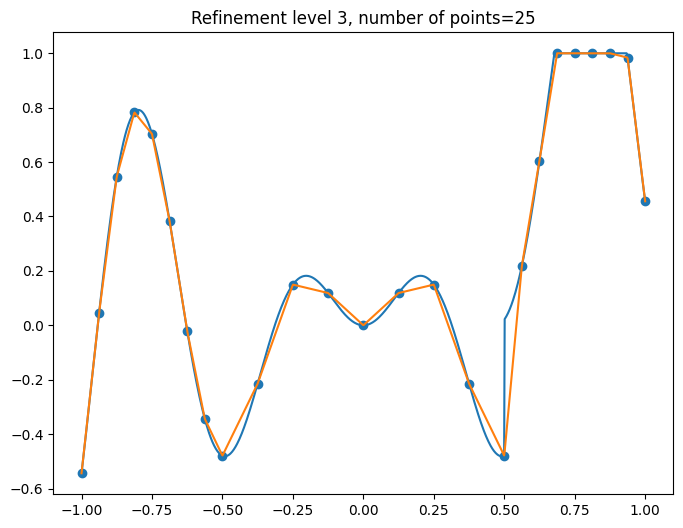

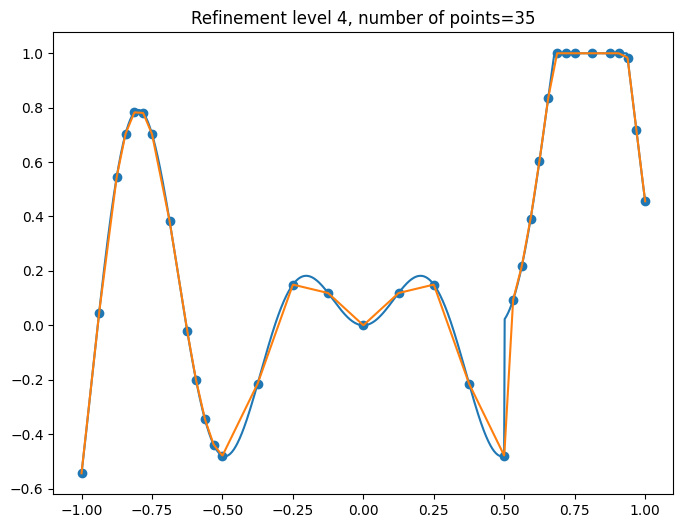

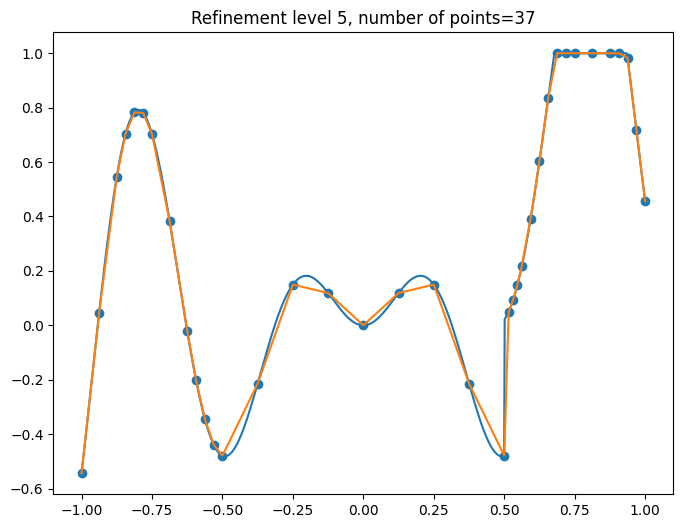

In [12]:
refinement_level = 6
fTol = 0.05

for k in range(refinement_level):
    adaptive_grid.setSurplusRefinement(fTolerance=fTol,iOutput=0, sCriteria="classic")
    x_train = adaptive_grid.getNeededPoints()
    y_train=function_1d(x_train)
    adaptive_grid.loadNeededPoints(y_train)
    x_train = adaptive_grid.getPoints()
    fig,ax=plt.subplots()
    ax.plot(x,function_1d(x))
    ax.scatter(x_train,function_1d(x_train))
    ax.plot(x_test, adaptive_grid.evaluateBatch(x_test.reshape(-1,1)))
    ax.set(title=f'Refinement level {k}, number of points={len(x_train)}')
    fig.show()
    if k==refinement_level:
        fig.savefig(PATH / 'figures/adaptive_sparse_grid.pdf')

### Sparse Grids in 2D

In [13]:
def function_2d(x:np.ndarray)->np.ndarray:
    return np.sin(5*x[:,[0]])*(2*x[:,[1]])+x[:,[0]]+(x[:,[0]]<0.5)

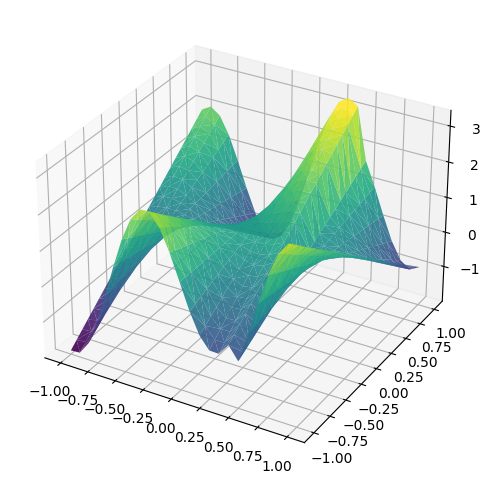

In [14]:
X = np.meshgrid(np.linspace(-1, 1, 25), np.linspace(-1, 1, 25))
X = np.column_stack((X[0].ravel(), X[1].ravel()))
Y = function_2d(X)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_trisurf(X[:,0],X[:,1],Y.flatten(),alpha=0.9,cmap='viridis')
fig.show()

In [15]:
sparse_grid  = TasmanianSparseGrid()
sparse_grid.makeLocalPolynomialGrid(iDimension=2, iOutputs=1, iDepth=6)
x_train = sparse_grid.getNeededPoints()
y_train=function_2d(x_train)
sparse_grid.loadNeededPoints(y_train)
n_train = len(x_train)

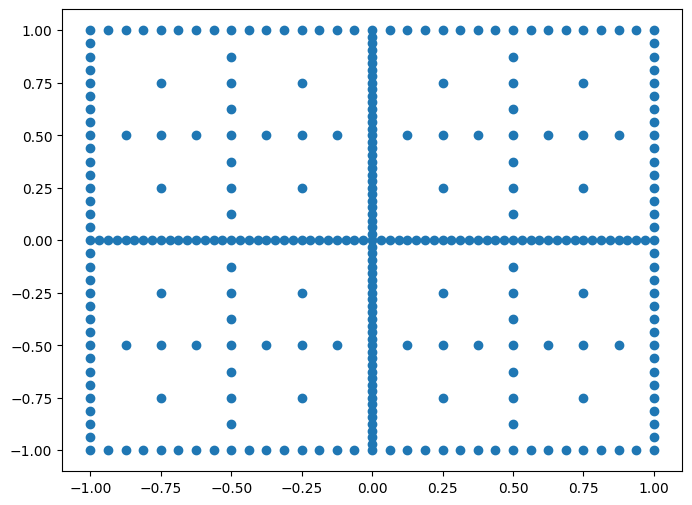

In [16]:
fig,ax=plt.subplots()
ax.scatter(x_train[:,0],x_train[:,1])
fig.show()

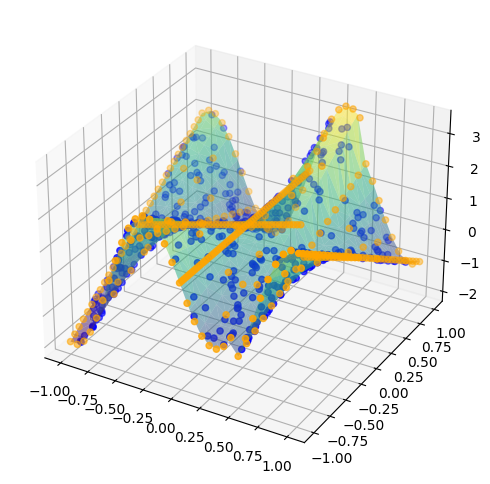

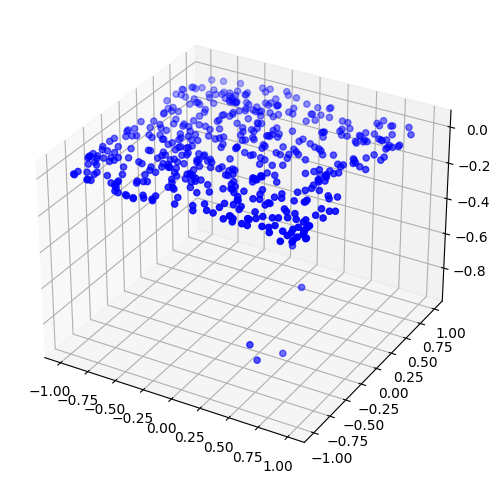

In [17]:
n_test = 500
x_test=np.random.uniform(-1,1,(n_test,2))
y_test = sparse_grid.evaluateBatch(x_test)


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_trisurf(X[:,0],X[:,1],Y.flatten(),alpha=0.5,cmap='viridis')
ax.scatter3D(x_train[:,0],x_train[:,1],y_train,c='orange')
ax.scatter3D(x_test[:,0],x_test[:,1],y_test,c='blue')
fig.show()

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(x_test[:,0],x_test[:,1],y_test-function_2d(x_test),c='blue')
fig.show()

In [18]:
n_cart = np.ceil(np.sqrt(n_train)).astype(int)
x_train = np.meshgrid(np.linspace(-1, 1, n_cart), np.linspace(-1, 1, n_cart))
x_train = np.column_stack((x_train[0].ravel(), x_train[1].ravel()))
y_train = function_2d(x_train)

In [19]:
cartesian_interpolator = RegularGridInterpolator(points = (np.linspace(-1, 1, n_cart),np.linspace(-1, 1, n_cart)),values = y_train.reshape(n_cart,n_cart,order='F'))

In [20]:
n_test = 500
x_test=np.random.uniform(-1,1,(n_test,2))
y_test = grid.evaluateBatch(x_test)


fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.plot_trisurf(X[:,0],X[:,1],Y.flatten(),alpha=0.5,cmap='viridis')
ax.scatter3D(x_train[:,0],x_train[:,1],y_train,c='orange')
ax.scatter3D(x_test[:,0],x_test[:,1],cartesian_interpolator(x_test),c='blue')
fig.show()

TasmanianInputError: ('llfX', 'ERROR: llfX.shape[1] should equal 1 instead it equals 2')

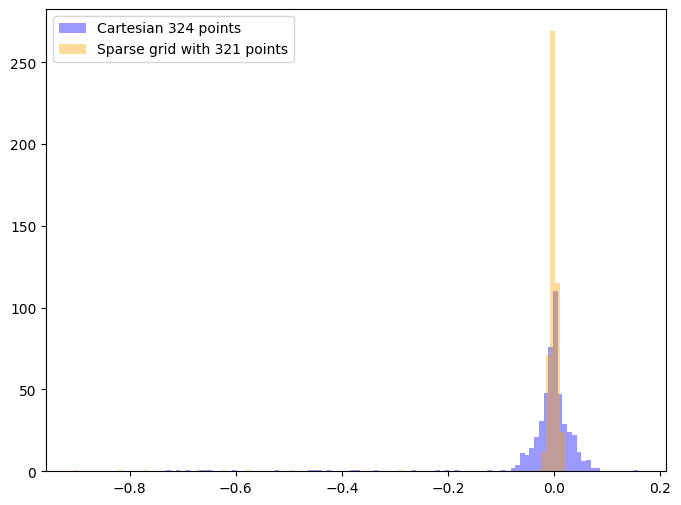

In [ ]:
fig,ax=plt.subplots()
ax.hist((cartesian_interpolator(x_test).reshape(-1,1)-function_2d(x_test)).flatten(),alpha=0.4,color='blue',bins=100, label=f'Cartesian {n_cart**2} points')
ax.hist((grid.evaluateBatch(x_test)-function_2d(x_test)).flatten(),alpha=0.4,color='orange',bins=100,label=f'Sparse grid with {n_train} points')
ax.legend()
fig.show()

### Refinement

In [36]:
adaptive_grid  = TasmanianSparseGrid()
adaptive_grid.makeLocalPolynomialGrid(iDimension=2, iOutputs=1, iDepth=2, iOrder=2)
x_train = adaptive_grid.getNeededPoints()
y_train=function_2d(x_train)
adaptive_grid.loadNeededPoints(y_train)

In [37]:
refinement_level = 6
fTol = 0.001

for k in range(refinement_level):
    adaptive_grid.setSurplusRefinement(fTolerance=fTol,iOutput=0, sCriteria="classic")
    x_train = adaptive_grid.getNeededPoints()
    y_train=function_2d(x_train)
    adaptive_grid.loadNeededPoints(y_train)
    x_train = adaptive_grid.getPoints()
x_train = adaptive_grid.getPoints()

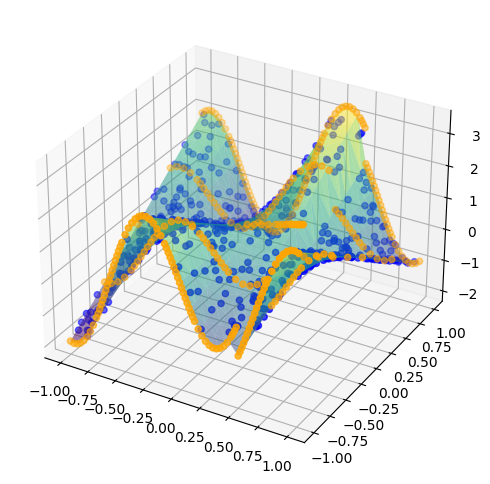

In [38]:
n_test = 500
x_test=np.random.uniform(-1,1,(n_test,2))
y_test = adaptive_grid.evaluateBatch(x_test)


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_trisurf(X[:,0],X[:,1],Y.flatten(),alpha=0.5,cmap='viridis')
ax.scatter3D(x_train[:,0],x_train[:,1],function_2d(x_train),c='orange')
ax.scatter3D(x_test[:,0],x_test[:,1],y_test,c='blue')
fig.show()

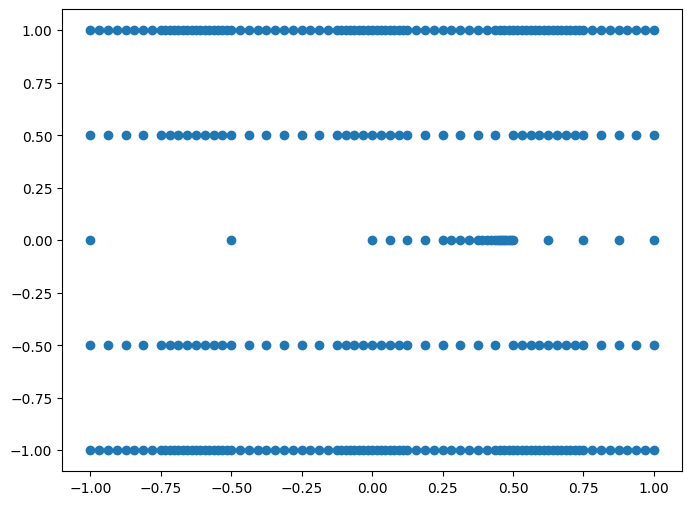

In [39]:
fig,ax=plt.subplots()
ax.scatter(x_train[:,0],x_train[:,1])
fig.show()

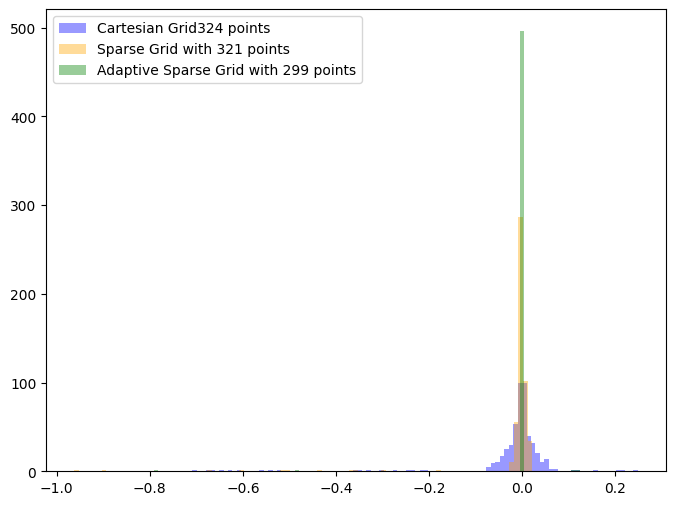

In [40]:
fig,ax=plt.subplots()
ax.hist((cartesian_interpolator(x_test).reshape(-1,1)-function_2d(x_test)).flatten(),alpha=0.4,color='blue',bins=100, label=f'Cartesian Grid{n_cart**2} points')
ax.hist((sparse_grid.evaluateBatch(x_test)-function_2d(x_test)).flatten(),alpha=0.4,color='orange',bins=100,label=f'Sparse Grid with {n_train} points')
ax.hist((adaptive_grid.evaluateBatch(x_test)-function_2d(x_test)).flatten(),alpha=0.4,color='green',bins=100,label=f'Adaptive Sparse Grid with {len(x_train)} points')
ax.legend()
fig.show()

## Gaussian Processes

In [16]:
x_train =  np.linspace(-1,1,10).reshape(-1,1)
y_train = function_1d(x_train)
kernel=RBF(length_scale=0.2)
gp=GaussianProcessRegressor(normalize_y=False,kernel=kernel)
gp = gp.fit(x_train,y_train)


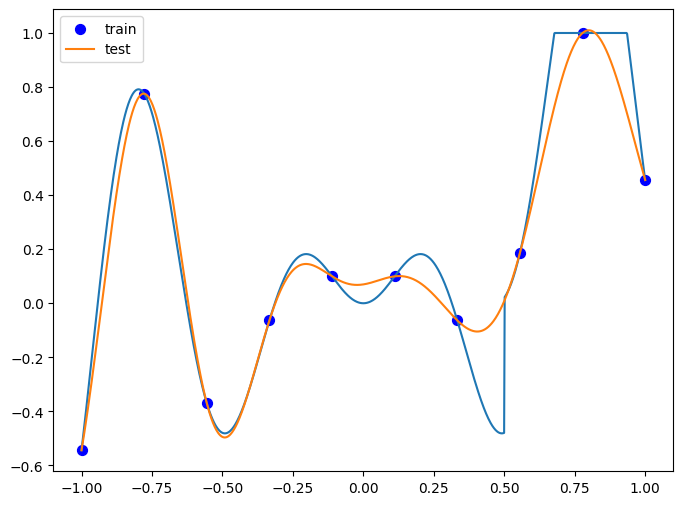

In [17]:
fig,ax=plt.subplots()
ax.plot(x,function_1d(x))
ax.scatter(x_train,y_train,c='b',s=50,alpha=1,label='train')
ax.plot(x_test,gp.predict(x_test.reshape(-1,1)),label='test')
ax.legend()
fig.show()
fig.savefig(PATH / 'figures/gaussian_process.pdf')

# JAX

For the GPU version, install it with:

`pip install --upgrade "jax[cuda11_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html`

Otherwise it will only use CPU

In [18]:
import jax
import numpy as np
import jax.numpy as jnp

In [19]:
numpy_matrix = np.random.uniform(size=(1000,1000))
jax_matrix = jnp.array(numpy_matrix)

In [20]:
%%timeit
numpy_matrix@numpy_matrix

2.5 ms ± 55.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
%%timeit
jax_matrix@jax_matrix

48.2 µs ± 29.6 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In `jax`, `jnp.inf*0` is `nan`, not 0

In [22]:
jnp.inf*0

nan

In `jnp.array`, is immutable so `x[0]=4` is not allowed. Instead: 

In [23]:
x = jnp.array([1,2,3])
x.at[0].set(4)

Array([4, 2, 3], dtype=int32)

Gradient

In [24]:
def f(x):
    return x**2

jax.grad(f)(0.2)

Array(0.4, dtype=float32, weak_type=True)

# Parallelization

In [25]:
print(f'Number of cpus available: {multiprocessing.cpu_count()}')

Number of cpus available: 208


In [26]:
def fun(x:float)->None:
    time.sleep(x)

In [27]:
%%timeit
with concurrent.futures.ProcessPoolExecutor(max_workers=10) as executor:
    list(executor.map(fun,[1]*10))

1.25 s ± 2.68 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
%%timeit
with concurrent.futures.ProcessPoolExecutor(max_workers=100) as executor:
    list(executor.map(fun,[1]*100))

3.37 s ± 185 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
%%timeit
with concurrent.futures.ProcessPoolExecutor(max_workers=100) as executor:
    list(executor.map(fun,[0.01]*100))

1.9 s ± 364 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
%%timeit
_ = [fun(0.01) for i in range(100)]

1.01 s ± 355 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
def batch(x):
    [fun(x) for i in range(50)]

In [32]:
%%timeit
with concurrent.futures.ProcessPoolExecutor(max_workers=2) as executor:
    list(executor.map(batch,[0.01]*2))

594 ms ± 942 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Neural Net interpolation

In [57]:
mlp = hk.transform(lambda x: hk.nets.MLP([1, 2, 3])(x))

In [41]:
import haiku as hk
import optax

def _interpolator(x):
    n_layers = 4
    n_nodes = 20
    for _ in range(n_layers + 1):
        x = hk.Linear(n_nodes)(x)
        x = jax.nn.relu(x)
    x = hk.Linear(1)(x)       
    return x



init, interpolator = hk.without_apply_rng(hk.transform(_interpolator))


@jax.jit
def mse_loss(params, x, y):
    preds = interpolator(params, x)
    return jnp.mean(jnp.square(preds - y))

@jax.jit
def train_step(params, x, y, opt_state):
    grad_fn = jax.grad(mse_loss)
    grad = grad_fn(params, x, y)
    updates, new_opt_state = optimizer.update(grad, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state

optimizer = optax.adam(1e-3)

x_train = jnp.linspace(-1,1,20).reshape(-1,1)

y_train = function_1d(x_train)

params = init(jax.random.PRNGKey(0), x_train)

opt_state = optimizer.init(params)

# Train the model
for i in range(1500):
    params, opt_state = train_step(params, x_train, y_train, opt_state)
    if i % 100 == 0:
        loss = mse_loss(params, x_train, y_train)
        print(f"Step {i}, loss={loss:.4f}")

Step 0, loss=0.2337
Step 100, loss=0.1353
Step 200, loss=0.0792
Step 300, loss=0.0061
Step 400, loss=0.0018
Step 500, loss=0.0016
Step 600, loss=0.0014
Step 700, loss=0.0005
Step 800, loss=0.0003
Step 900, loss=0.0001
Step 1000, loss=0.0001
Step 1100, loss=0.0000
Step 1200, loss=0.0000
Step 1300, loss=0.0000
Step 1400, loss=0.0000


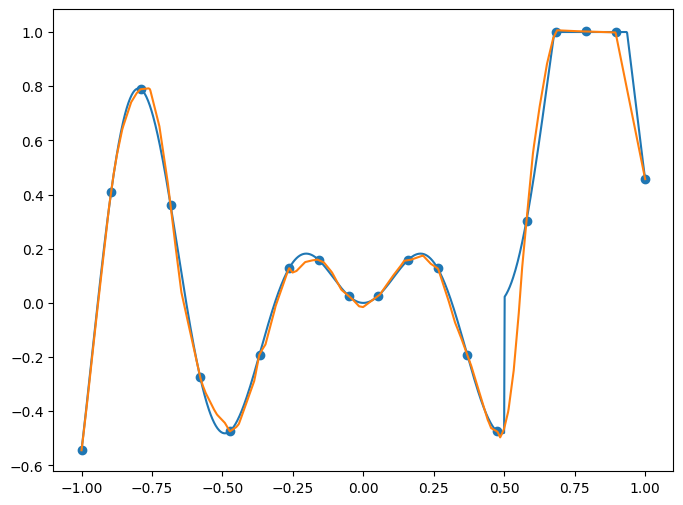

In [47]:
x = np.linspace(-1,1,1000)
fig,ax=plt.subplots()
ax.plot(x, function_1d(x))
ax.plot(x,interpolator(params, x.reshape(-1,1)), label='Neural Network')
ax.scatter(x_train,interpolator(params, x_train.reshape(-1,1)), label='Neural Network')
fig.show()
fig.savefig(PATH / 'figures/neural_network.pdf')